# 3 Bus Model for Debugging

We will create a 3-bus model. Mkae sure that it is functional by running AC OPF, then use it to test our SDP OPF method.

In [2]:
import pandapower.networks as nw
import pandapower as pp
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.sparse import csr_matrix
import mosek
import plotly.express as px
import pandapower.plotting as plot
import sys

np.set_printoptions(threshold=sys.maxsize)

The grid will have three generators, each connected to a bus. 
The grid will have one load, connected to bus

| Generator Parameters |   Value |
| -------- | ------- |
| external grid capacity  |  -0.5 of base_MVA to 0.5 of base_MVA   |
| gas generator capacity  | 0 to base_MVA (150)   |
| cost of gas generator 1 | 20 (pound per MWh)     |
| cost of gas generator 2 | 30 (pound per MWh)     |
| cost of gas generator 3 | 20 (pound per MWh)     |

In [92]:
# Create an empty network
net = pp.create_empty_network()

# Set base values for the per unit system
Vbase = 110 # Base voltage in kV
Sbase = 150 # Base apparent power in MVA
Zbase = Vbase**2 / Sbase  # in Ohms
Ybase = 1 / Zbase # base admittance in S
# Line Impedances in Ohms
r_ohm = 0 # let's assume we have negligible resistance
x_ohm = 0.5*Zbase
length_km = 1  # nominal length
min_vm_pu = 0.95
max_vm_pu = 1.05

#Convert line flow limits from MW to kA (approx)
def mw_to_ka(p_mw, v_kv=Vbase):
    return p_mw / (v_kv * (3)**0.5)

#Create the buses
b0 = pp.create_bus(net, vn_kv=Vbase, min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu, name="Bus 0")
b1 = pp.create_bus(net, vn_kv=Vbase, min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu, name="Bus 1")
b2 = pp.create_bus(net, vn_kv=Vbase, min_vm_pu=min_vm_pu, max_vm_pu=max_vm_pu, name="Bus 2")

# Create external grid (slack bus at Bus 0)
ext = pp.create_ext_grid(net, bus=b0, vm_pu=1.0,  min_p_mw=0, max_p_mw=Sbase, min_q_mvar=-1/4*Sbase, max_q_mvar=Sbase,  name="Slack Bus")

#Create the generators 
gen0 = pp.create_gen(net, bus=b0, p_mw=0, min_p_mw=0, max_p_mw=Sbase, min_q_mvar=-1/4*Sbase, max_q_mvar=Sbase, name="Generator 0")
gen1 = pp.create_gen(net, bus=b1, p_mw=0, min_p_mw=0, max_p_mw=Sbase, min_q_mvar=-1/4*Sbase, max_q_mvar=Sbase, name="Generator 1")
gen2 = pp.create_gen(net, bus=b2, p_mw=0, min_p_mw=0, max_p_mw=Sbase, min_q_mvar=-1/4*Sbase, max_q_mvar=Sbase, name="Generator 2")

# Add generator costs
pp.create_poly_cost(net, element=gen0, et='gen', cp1_eur_per_mw=20)
pp.create_poly_cost(net, element=gen1, et='gen', cp1_eur_per_mw=30)
pp.create_poly_cost(net, element=gen2, et='gen', cp1_eur_per_mw=40)
pp.create_poly_cost(net, element=ext, et='ext_grid', cp1_eur_per_mw=75)

#Create the loads
pp.create_load(net, bus=b1, p_mw=3*Sbase, q_mvar=0.5*Sbase, name="L0")

#Show buses
net.gen


,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,min_p_mw,max_p_mw
0,Generator 0,0,0.0,1.0,NaN,-37.5,150.0,1.0,False,True,0.0,None,0.0,150.0
1,Generator 1,1,0.0,1.0,NaN,-37.5,150.0,1.0,False,True,0.0,None,0.0,150.0
2,Generator 2,2,0.0,1.0,NaN,-37.5,150.0,1.0,False,True,0.0,None,0.0,150.0


No or insufficient geodata available --> Creating artificial coordinates. This may take some time


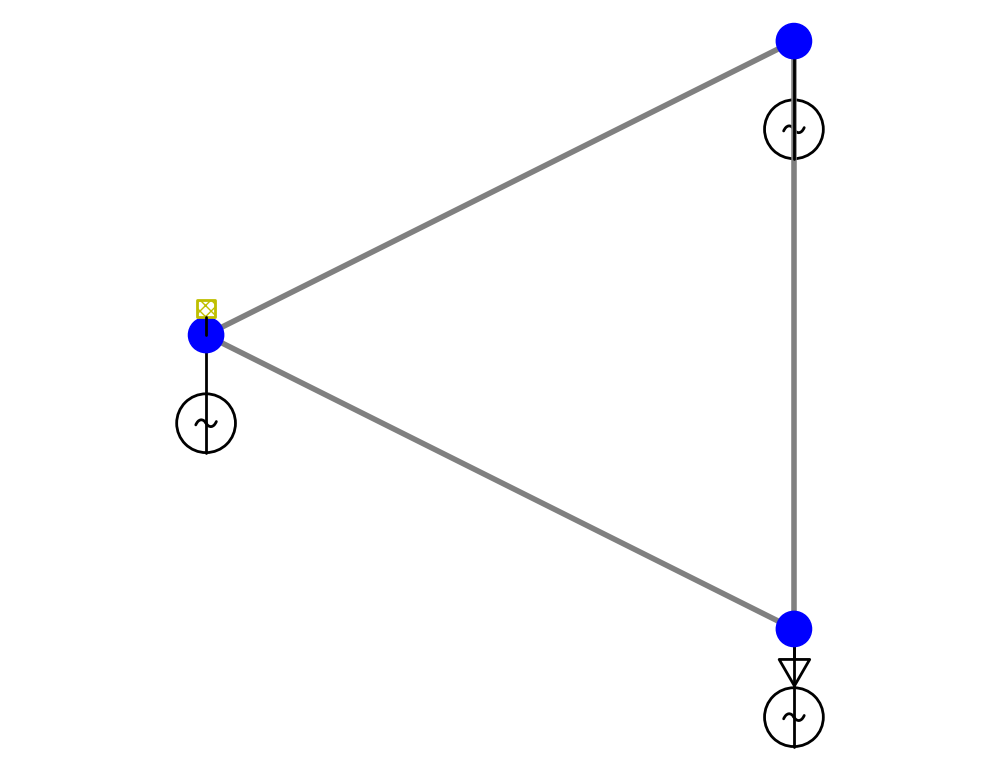

<Axes: >

In [94]:
# Add lines with limits
pp.create_line_from_parameters(net, b0, b1, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(300), name="line01")

pp.create_line_from_parameters(net, b0, b2, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line02")

pp.create_line_from_parameters(net, b1, b2, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line12")

plot.simple_plot(net, show_plot=True, plot_loads=True, plot_gens=True, gen_size =5, load_size=3, line_width=4, bus_size=3)

In [96]:
# Run AC Optimal Power Flow
pp.runopp(net)
print("AC OPF")
print(net.res_bus)
print("Optimal Cost is", net.res_cost)

AC OPF
      vm_pu     va_degree        p_mw     q_mvar      lam_p         lam_q
0  1.000000 -7.530437e-19 -150.000007 -43.544439  67.003713 -8.419587e-07
1  0.970528 -3.075855e+01  300.000003 -58.992395  67.003716  5.852034e-06
2  1.020855 -2.049338e-01 -149.999996 -63.070914  67.003712  1.056727e-07
Optimal Cost is 13500.000371318043


## SDP OPF
We need to construct the Ybus. Let's do it manually first.

We assumed that there's no resistence in thsi grid, which means admittance is just B, susceptance, which is the inverse of reactance (x). 
$$
\begin{bmatrix}
P_1\\
P_2\\
\vdots\\
P_N
\end{bmatrix}=\textbf{B}\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}=
\begin{bmatrix}
B_{12} + B_{13} + \dots + B_{1N} & -B_{12}                 & \dots & -B_{1N}\\
-B_{21}                          & B_{21} + B_{22} + \dots + B_{2N} & \dots & -B_{2N}\\
\vdots                           & \vdots                           & \ddots & \vdots\\
-B_{N1}                          & -B_{N2}                          & \dots & B_{N1} + B_{N2} + \dots
\end{bmatrix}
\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}
$$

where $B_{ij} = \frac{1}{x_{ij}}$

In [99]:
x_ohm

40.333333333333336

In [101]:
print('x_ohm:', x_ohm)
B = np.array([[1/x_ohm +1/x_ohm, -1/x_ohm, -1/x_ohm], 
              [-1/x_ohm, 1/x_ohm + 1/x_ohm,  -1/x_ohm], 
              [-1/x_ohm, -1/x_ohm,  1/x_ohm+1/x_ohm]])
print('Ybus (by hand):', B)

x_ohm: 40.333333333333336
Ybus (by hand): [[ 0.04958678 -0.02479339 -0.02479339]
 [-0.02479339  0.04958678 -0.02479339]
 [-0.02479339 -0.02479339  0.04958678]]


In [103]:
pp.runpp(net)  # AC power flow (needed for Ybus)
Ybus = net._ppc["internal"]["Ybus"].todense()
Ybus = Ybus / Ybase # To change it into per unit
print('Ybus (by power flow):', Ybus)

Ybus (by power flow): [[0.-48400.j 0.+24200.j 0.+24200.j]
 [0.+24200.j 0.-48400.j 0.+24200.j]
 [0.+24200.j 0.+24200.j 0.-48400.j]]


They are pretty close, which is a good sign.

## Extract Network Information

In [107]:

n = len(net.bus)  # Number of buses

#we need line information to add line flow constraints
# Extract line connections as (from_bus, to_bus) tuples
lines = list(zip(net.line['from_bus'].astype(int), net.line['to_bus'].astype(int)))

#################### series admittance ##########################

y_lines = {}
for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    y_lines[(l,m)]= -Ybus[l, m]

###################### shunt admittance set to zero for now ######################

# Note c_nf_per_km (float) - line capacitance in nano Farad per km
y_shunt = {}
f = 50  # System frequency (Hz); change to 60 if using US grid
omega = 2 * np.pi * f  # Angular frequency (rad/s)

for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    C_per_km = row['c_nf_per_km']  # Capacitance in nF/km
    length = row['length_km']      # Line length in km
    C_total = C_per_km * 1e-9 * length  # Total capacitance (F)
    B_total = omega * C_total      # Total susceptance (S)
    y_shunt_lm = 1j * B_total / 2  # Half at each end (π-model)
    y_shunt_pu = y_shunt_lm/Ybase
    y_shunt[(l,m)]= 0
    
#y_shunt = np.zeros((n, n), dtype=complex)
#for k in range(n):
        #y_shunt[k, k] = 1/2 * (Ybus[k, k] + sum(Ybus[k, m] for m in range(n) if m != k))

##################### Double check s_max ####################################

# Define s_max for each line using max_i_ka and Vbase
s_max = {}
p_max = {}
max_v_diff_lm = {}
for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    Imax = row['max_i_ka']  # in kA   # IS This phase current or line current? #################################
    # Smax in MVA
    s_max[(l, m)] = np.sqrt(3) * Vbase * Imax  
    # Since we don't have info on P^max_lm, we will assume it is 95% of S^max_lm.
    p_max[(l, m)] = 0.95 * s_max[(l, m)]
    # Since we don't have the maximum voltage difference across a line, we will estimate it
    v_max_l = net.bus.loc[l, "max_vm_pu"]
    v_min_m = net.bus.loc[m, "min_vm_pu"]
    v_max_m = net.bus.loc[m, "max_vm_pu"]
    v_min_l = net.bus.loc[l, "min_vm_pu"]
    max_v_diff_lm[(l,m)] = max(abs(v_max_l - v_min_m), abs(v_max_m - v_min_l))

######################################################################

# Extract generator information for generation constraints
# Combine all generators, keep them separate
all_gen = pd.concat([
    net.gen.assign(type="gen"),
    net.sgen.assign(type="sgen"),
    net.ext_grid.assign(type="ext")
])
all_gen.reset_index(inplace=True)
gen_buses = all_gen["bus"].values
#all_gen = all_gen.groupby("bus").sum(numeric_only=True).reset_index() #if multiple generators are present at a bus, combine them.

# Extract load for generation constraints
load_buses = net.load["bus"].values #index of the load buses.
#load active and reactive power for load
p_load = np.zeros(n)
q_load = np.zeros(n)
all_load = net.load.groupby("bus").sum(numeric_only=True).reset_index() #if multiple loads are present at a bus, combine them.
for i,row in all_load.iterrows():
    p_load[int(row['bus'])] = row['p_mw'] 
    q_load[int(row['bus'])] = row['q_mvar']
    
# Extract min and max power for generation constraints
min_p = np.zeros(n)
max_p = np.zeros(n)
min_q = np.zeros(n)
max_q = np.zeros(n)

for i,row in all_gen.iterrows():
    min_p[int(row['bus'])] = row['min_p_mw'] 
    max_p[int(row['bus'])] = row['max_p_mw']
    min_q[int(row['bus'])] = row['min_q_mvar'] 
    max_q[int(row['bus'])] = row['max_q_mvar']  
    
# Voltage limits
min_v_pu = net.bus["min_vm_pu"].values ** 2  # Squared for SDP
max_v_pu = net.bus["max_vm_pu"].values ** 2

# Slack bus voltage
vm_slack = net.ext_grid['vm_pu'][0] #initial voltage of the slack

# Slack bus
slack_bus = int(net.ext_grid["bus"].iloc[0])

#######################################################################

# Extract generator cost coefficients from net.poly_cost
c2 = np.zeros(n)
c1 = np.zeros(n)
c0 = np.zeros(n)
all_cost = net.poly_cost.groupby("element").sum(numeric_only=True).reset_index() #if multiple loads are present at a bus, combine them.
for i,row in all_cost.iterrows():
    c2[int(row['element'])] = row['cp2_eur_per_mw2'] # Quadratic cost coefficients
    c1[int(row['element'])] = row['cp1_eur_per_mw']  # Linear cost coefficients
    c0[int(row['element'])] = row['cp0_eur']  # Constant cost coefficients

In [109]:
all_gen

,index,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,min_p_mw,max_p_mw,q_mvar,current_source,va_degree
0,0,Generator 0,0,0.0,1.0,NaN,-37.5,150.0,1.0,False,True,0.0,gen,0.0,150.0,NaN,NaN,NaN
1,1,Generator 1,1,0.0,1.0,NaN,-37.5,150.0,1.0,False,True,0.0,gen,0.0,150.0,NaN,NaN,NaN
2,2,Generator 2,2,0.0,1.0,NaN,-37.5,150.0,1.0,False,True,0.0,gen,0.0,150.0,NaN,NaN,NaN
3,0,Slack Bus,0,NaN,1.0,NaN,-37.5,150.0,NaN,NaN,True,1.0,ext,0.0,150.0,NaN,NaN,0.0


In [111]:


############################## Initialize ###################################
# Define our problem matrix, W. It is 2n x 2n, where the first n rows and columns correspond to the real part of the voltage, and the second n rows and columns correspond to the imaginary part of the voltage.
W = cp.Variable((2*n, 2*n), PSD=True)

# Initialize the problem matrices
Y_set = {} # Hermitian part of Y_j
Y_bar_set = {} # Skewed Hermitian part of Y_j
M_set = {}

for k in range(n):
    e_k = np.zeros((n, 1))
    e_k[k] = 1
    Yk = e_k @ e_k.T @ Ybus #Yk is the admittance matrix with only the (k,k) entry, everything else is zero
    
    #Y_k is the Hermitian part of Y_k
    Y_k = 1/2 * np.block([
        [np.real(Yk + Yk.T),     np.imag(Yk.T - Yk)],
        [np.imag(Yk - Yk.T),     np.real(Yk + Yk.T)]
    ])
    #print('Size of Y_k', Y_k.shape)
    #Y_kbar is the skewed Hermitian part of Y_k
    Y_kbar = -1/2 * np.block([
        [np.imag(Yk + Yk.T),    np.real(Yk - Yk.T)],
        [np.real(Yk.T - Yk),    np.imag(Yk + Yk.T)]
    ])
    #print('Size of Y_kbar', Y_kbar.shape)
    #M_k is the matrix that will be used to enforce the voltage constraints
    M_k = np.block([
        [e_k @ e_k.T,       np.zeros((n, n))],
        [np.zeros((n, n)), e_k @ e_k.T]
    ])
    #print('Size of M_k', M_k.shape)
    Y_set[k] = Y_k
    Y_bar_set[k] = Y_kbar
    M_set[k] = M_k

# Create the matrices for the line constraints
M_line_set = {}
Y_line_set = {}
Y_bar_line_set = {}

for (l, m) in lines:  # lines is a list of (l, m) tuples

    e_l = np.zeros((n, 1))
    e_m = np.zeros((n, 1))
    e_l[l] = 1
    e_m[m] = 1
    delta = e_l - e_m
    M_lm = np.block([
        [delta @ delta.T,          np.zeros((n, n))],
        [np.zeros((n, n)), delta @ delta.T]
    ])
    M_line_set[(l, m)] = M_lm

    # y_lm and y_shunt_lm from precious
    y_lm = y_lines[(l, m)]         
    y_shunt_lm = y_shunt[(l, m)]

    Ylm = (y_shunt_lm + y_lm) * (e_l @ e_l.T) - y_lm * (e_l @ e_m.T)
    #print('Size of Y_lm', Ylm.shape)

    # Real-valued lifting
    Re_Y = np.real(Ylm + Ylm.T)
    Im_Y = np.imag(Ylm.T - Ylm)
    Re_Y_skew = np.real(Ylm - Ylm.T)
    Im_Y_sum = np.imag(Ylm + Ylm.T)

    Y_lm = 1/2 * np.block([
        [Re_Y,      Im_Y],
        [-Im_Y,     Re_Y]
    ])
    #print('Size of Y_lm', Y_lm.shape)
    Y_lmbar = -1/2 * np.block([
        [Im_Y_sum,      Re_Y_skew],
        [-Re_Y_skew,    Im_Y_sum]
    ])
    #print('Size of Y_lmbar', Y_lmbar.shape)
    Y_line_set[(l, m)] = Y_lm
    Y_bar_line_set[(l,m)] = Y_lmbar

############################## Objective Function #############################


alpha = cp.Variable(n)
objective = cp.Minimize(cp.sum(alpha))
    
############################## Constraints ####################################
constraints = []
#P_G = cp.Variable(len(all_gen)) #Create a new active power variable for each generator (specifically for multiple generators at one bus)
#Q_G = cp.Variable(len(all_gen)) ##Create a new reactive power variable for each generator
Pin = {}
Qin = {}
for k in range(n):

    ############################## Power Constraints ###################################
    
    Pin[k] = cp.trace(Y_set[k] @ W) * Sbase
    Qin[k] = cp.trace(Y_bar_set[k] @ W) * Sbase
    #print('Pin for bus', k, Pin[k])
    #print('Qin for bus', k, Qin[k])
    
    constraints.append(min_p[k] - p_load[k] <= Pin[k]) #constraint 4a
    constraints.append(Pin[k] <= max_p[k] - p_load[k]) #constraint 4a
    constraints.append(min_q[k] - q_load[k] <= Qin[k]) #constraint 4b
    constraints.append(Qin[k] <= max_q[k] - q_load[k]) #constraint 4b


    ############################# Cost Constraint #######################################
    
    a_k = c0[k] + c1[k] * p_load[k] 
    b_k = float(np.sqrt(c2[k])) * p_load[k]

    top_left = c1[k] * Pin[k] - alpha[k] + a_k
    top_right = float(np.sqrt(c2[k])) * Pin[k] + b_k


    Schur = cp.bmat([
        [top_left, top_right],
        [top_right, -1]
    ])
    constraints.append(Schur << 0) # constraint 6
    
    ############################## Voltage Constraints #####################################
    # For the slack bus, we fix the voltage magnitude since it is not adjustable
    if k == slack_bus:
        constraints.append(cp.trace(M_set[k] @ W) == vm_slack**2)

    else:

        # Voltage constraints (except slack)
        constraints.append(min_v_pu[k] <= cp.trace(M_set[k] @ W)) #constraint 4c, note that min_v_pu is already squared and in pu
        constraints.append(cp.trace(M_set[k] @ W) <= max_v_pu[k]) #constraint 4c


######################## Line Flow Constraints ####################################

P_lm = {}
Q_lm = {}
for (l, m) in lines:
    Plm = cp.trace(Y_line_set[(l, m)] @ W) * Sbase
    Qlm = cp.trace(Y_bar_line_set[(l, m)] @ W) * Sbase
    Smax = s_max[(l, m)]
    
    P_lm[(l, m)] = Plm
    Q_lm[(l, m)] = Qlm

    S_constr = cp.bmat([
        [-Smax**2, Plm, Qlm],
        [Plm, -1, 0],
        [Qlm, 0, -1]
    ])

    #constraints.append(Plm <= p_max[(l,m)])  # constraint 4e
    #constraints.append(cp.trace(M_line_set[(l,m)]@W) <= max_v_diff_lm[l,m]**2)  # constraint 4f
    #constraints.append(S_constr << 0) # constraint 5

################# Positive semidefinite constraint   #####################################
constraints.append(W >> 0) ##constraint 4g

In [113]:
print("======== BUS CONSTRAINTS CHECK ========")
for k in range(n):
    print(f"Bus {k}")
    print(f"  P_gen ∈ [{min_p[k]}, {max_p[k]}], Load = {p_load[k]}")
    print(f"    → Net injection must be in [{min_p[k] - p_load[k]}, {max_p[k] - p_load[k]}]")
    print(f"  Q_gen ∈ [{min_q[k]}, {max_q[k]}], Load = {q_load[k]}")
    print(f"    → Net injection must be in [{min_q[k] - q_load[k]}, {max_q[k] - q_load[k]}]")
    print(f"  Voltage ∈ [{min_v_pu[k]}, {max_v_pu[k]}]")

======== BUS CONSTRAINTS CHECK ========
Bus 0
  P_gen ∈ [0.0, 150.0], Load = 0.0
    → Net injection must be in [0.0, 150.0]
  Q_gen ∈ [-37.5, 150.0], Load = 0.0
    → Net injection must be in [-37.5, 150.0]
  Voltage ∈ [0.9025, 1.1025]
Bus 1
  P_gen ∈ [0.0, 150.0], Load = 450.0
    → Net injection must be in [-450.0, -300.0]
  Q_gen ∈ [-37.5, 150.0], Load = 75.0
    → Net injection must be in [-112.5, 75.0]
  Voltage ∈ [0.9025, 1.1025]
Bus 2
  P_gen ∈ [0.0, 150.0], Load = 0.0
    → Net injection must be in [0.0, 150.0]
  Q_gen ∈ [-37.5, 150.0], Load = 0.0
    → Net injection must be in [-37.5, 150.0]
  Voltage ∈ [0.9025, 1.1025]


In [115]:
total_max_p = np.sum(max_p)
total_min_p = np.sum(min_p)
total_load = np.sum(p_load)

print(f"\nTotal real generation: [{total_min_p}, {total_max_p}]")
print(f"Total real load: {total_load}")


Total real generation: [0.0, 450.0]
Total real load: 450.0


In [117]:
# Solve the SDP
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose =True)

# Print results
print("Problem Status:", prob.status)
print("Optimal cost EUR:", prob.value)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jul 15 09:47:14 PM: Your problem has 39 variables, 65 constraints, and 0 parameters.
(CVXPY) Jul 15 09:47:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 15 09:47:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 15 09:47:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 15 09:47:14 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 15 09:47:14 PM: Compiling problem (target solver=MOSEK).
(C

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.